
<div align="center"> 

# Closed-Form Linear Regression

<p align="center"> 
  <img src="https://mad-institute.com/images/universitys/iranuniversity2.png" alt="IUST Logo" width="180" height="180"> 
</p> 

**University:** IRAN University of Science and Technology  
**Course:** Deep Learning  
**Term:** First semester of academic year 1404–1405 
</div>



## Notebook: Closed-Form Linear Regression (OLS) — *Evaluation-Only*

This notebook walks you through **Ordinary Least Squares** with **closed-form solutions** (no gradients):
- Build a design matrix and fit OLS using **`pinv`** and **`lstsq`**.
- Evaluate **MSE** and **MAE** and analyze where they **disagree**.
- Visualize residuals and per-example contributions.
- Run a simple **k-fold** evaluation and an **outlier sensitivity** mini-experiment.

> **Policy for this course unit:** Do **not** use model selection, regularization, dropout, label smoothing, adversarial training, backpropagation, or any gradient-based optimizer. We only compute **forward predictions** and **report metrics**.



### Learning Objectives
1. Implement closed-form OLS with `np.linalg.pinv` and `np.linalg.lstsq`.
2. Compute and compare **MSE** vs **MAE** on the **same predictions**.
3. Inspect disagreements via per-example contributions and residual views.
4. Run k-fold evaluation and study sensitivity to **outliers** — still **evaluation-only**.


In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(42)  # Reproducibility
print("NumPy:", np.__version__, "| pandas:", pd.__version__)


NumPy: 2.3.1 | pandas: 2.3.1



## Part A — Data Generation (Synthetic)

We build a simple **1D-to-1D** regression dataset with optional sinusoidal ripple and a few **outliers**.

**TODO ideas:**
- Change noise level, outlier fraction/magnitude to see how **MSE vs MAE** react.
- Change the ground-truth function to be more nonlinear and see what happens to OLS.


In [ ]:
# ----------------------------- TODO: configurable data generator -----------------------------

# TODO: choose number of samples (e.g., 50, 200, 1000)
# n = ...

# TODO: define input domain range
# x_min, x_max = ...

# TODO: set Gaussian noise standard deviation
# sigma = ...

# TODO: specify fraction of outliers (0.0 to ~0.1)
# outlier_frac = ...

# TODO: set magnitude for outlier noise
# outlier_mag = ...


# ----------------------------- Ground-truth function -----------------------------
def f_true(x):
    # TODO: choose and implement one of the versions below
    # (linear + ripple) or (pure linear) or (nonlinear)
    pass


# ----------------------------- Data generation -----------------------------

# TODO: generate input points uniformly in the given range
# X = ...

# TODO: compute ground-truth outputs
# y_clean = ...

# TODO: add Gaussian noise
# noise = ...

# TODO: inject outliers by perturbing a random subset
# k = ...
# if k > 0:
#     idx = ...
#     noise[idx] += ...

# TODO: combine clean outputs and noise
# y = ...


# ----------------------------- Wrap into DataFrame -----------------------------
df = pd.DataFrame({"x": X, "y": y, "y_clean": y_clean})
df.head()


,x,y,y_clean
0,-3.000000,-5.515833,-5.664847
1,-2.969849,-5.678272,-5.636793
2,-2.939698,-5.412820,-5.607126
3,-2.909548,-5.118689,-5.575598
4,-2.879397,-5.612219,-5.541973


In [ ]:
import unittest
import numpy as np

class TestSyntheticDataGenerator(unittest.TestCase):
    def test_basic_shapes(self):
        # X, y, and y_clean must have the same length (equal to n)
        self.assertEqual(len(X), n)
        self.assertEqual(len(y), n)
        self.assertEqual(len(y_clean), n)
        # DataFrame should have n rows and 3 columns
        self.assertEqual(df.shape, (n, 3))

    def test_domain(self):
        # X should span from x_min to x_max and be monotonically increasing
        self.assertAlmostEqual(X[0], x_min, places=7)
        self.assertAlmostEqual(X[-1], x_max, places=7)
        self.assertTrue(np.all(np.diff(X) > 0))

    def test_y_composition(self):
        # y must be the sum of y_clean and noise
        self.assertTrue(np.allclose(y, y_clean + noise))

    def test_no_nans_or_infs(self):
        # No NaN or Inf values allowed in any array
        for arr in [X, y_clean, noise, y]:
            self.assertFalse(np.isnan(arr).any(), "Found NaN values")
            self.assertFalse(np.isinf(arr).any(), "Found Inf values")

    def test_f_true_signature(self):
        # f_true(0) should return 0.5 with default linear+ripple definition
        self.assertAlmostEqual(float(f_true(np.array([0.0]))[0]), 0.5, places=7)

    def test_outlier_bookkeeping(self):
        # k should equal round(outlier_frac * n)
        self.assertEqual(k, int(round(outlier_frac * n)))
        # If outliers exist, their indices should be valid and unique
        if k > 0:
            self.assertIn('idx', globals(), "idx should exist when k>0")
            self.assertEqual(len(idx), k)
            self.assertTrue(np.all((idx >= 0) & (idx < n)))
            self.assertEqual(len(np.unique(idx)), k)

    def test_outlier_effect_when_present(self):
        # If outliers exist, their noise magnitude should be significantly larger
        if k > 0:
            self.assertGreater(np.mean(np.abs(noise[idx])), 3.0 * sigma)

    def test_reasonable_noise_scale(self):
        # If there are no outliers, noise std should be close to sigma
        if k == 0:
            est = np.std(noise)
            self.assertTrue(abs(est - sigma) < max(0.25 * sigma, 1e-6),
                            f"std(noise)={est:.3f} too far from sigma={sigma:.3f}")

# Run the test suite directly in the notebook
suite = unittest.TestLoader().loadTestsFromTestCase(TestSyntheticDataGenerator)
unittest.TextTestRunner(verbosity=2).run(suite)



## Part B — Train/Test Split (No leakage)

We do a simple contiguous split (or shuffle first if you wish) to evaluate OLS fairly.


In [ ]:
# Shuffle indices for a random split (set seed above for reproducibility)
# TODO: generate a random permutation of row indices for splitting
# perm = ...

# TODO: choose the train/test split ratio (e.g., 0.7 for 70% train)
# train_ratio = ...

# TODO: compute number of training samples based on the ratio
# n_train = ...

# TODO: slice the permuted indices into train and test splits
# train_idx = ...
# test_idx  = ...

# TODO: build the train/test DataFrames using iloc; sort by "x" and reset the index
# df_train = ...
# df_test  = ...

print("Train size:", len(df_train), "| Test size:", len(df_test))


Train size: 140 | Test size: 60


In [ ]:
import unittest
import numpy as np
import pandas as pd

class TestRandomSplit(unittest.TestCase):
    def test_perm_is_valid_permutation(self):
        # perm must be a permutation of 0..len(df)-1 with no duplicates
        n_total = len(df)
        self.assertEqual(len(perm), n_total)
        self.assertEqual(len(np.unique(perm)), n_total)
        self.assertTrue(np.array_equal(np.sort(perm), np.arange(n_total)))

    def test_split_sizes(self):
        # n_train must be consistent with train_ratio
        n_total = len(df)
        self.assertEqual(n_train, int(train_ratio * n_total))
        # The split indices should partition perm
        self.assertEqual(len(train_idx), n_train)
        self.assertEqual(len(test_idx), n_total - n_train)

    def test_disjoint_and_cover_all(self):
        # Train and test index sets should be disjoint and cover all indices
        set_train = set(map(int, np.array(train_idx).tolist()))
        set_test  = set(map(int, np.array(test_idx).tolist()))
        self.assertTrue(set_train.isdisjoint(set_test))
        self.assertEqual(len(set_train | set_test), len(df))

    def test_train_test_from_correct_rows(self):
        # df_train/df_test should come from the right rows of df (order aside due to sorting)
        # Compare using sets of (x, y, y_clean) tuples to be order-invariant
        def rows_as_tuples(frame):
            return set(map(tuple, np.round(frame[["x", "y", "y_clean"]].values, 12)))
        # Raw slices before sorting/resetting
        raw_train = df.iloc[train_idx]
        raw_test  = df.iloc[test_idx]
        self.assertEqual(rows_as_tuples(df_train), rows_as_tuples(raw_train))
        self.assertEqual(rows_as_tuples(df_test), rows_as_tuples(raw_test))

    def test_sorted_by_x_and_reset_index(self):
        # After sorting by "x", values must be non-decreasing and index must be reset to 0..n-1
        for part in [df_train, df_test]:
            self.assertTrue(np.all(np.diff(part["x"].values) >= 0))
            self.assertTrue(np.array_equal(part.index.values, np.arange(len(part))))

    def test_no_nan_inf_in_splits(self):
        # No NaN/Inf allowed in split frames
        for part in [df_train, df_test]:
            vals = part[["x", "y", "y_clean"]].values
            self.assertFalse(np.isnan(vals).any(), "Found NaN values in split")
            self.assertFalse(np.isinf(vals).any(), "Found Inf values in split")

    def test_non_trivial_split(self):
        # Sanity: unless the user set pathological ratios, each split should be >0 in size
        # (If someone sets ratio 0.0 or 1.0 intentionally, this test can be adjusted.)
        self.assertGreater(len(df_train), 0, "Train split is empty; adjust train_ratio")
        self.assertGreater(len(df_test), 0, "Test split is empty; adjust train_ratio")

suite = unittest.TestLoader().loadTestsFromTestCase(TestRandomSplit)
unittest.TextTestRunner(verbosity=2).run(suite)



## Part C — Closed-Form OLS (`pinv` and `lstsq`)

We build a **design matrix** with a bias column, then estimate coefficients using either:
- `β = pinv(Xb) @ y` (Moore-Penrose pseudoinverse)  
- `β = lstsq(Xb, y)` (least-squares solver)

> We prefer `pinv`/`lstsq` over `inv(XᵀX)` for **numerical stability**.



---

This section covers how to **construct the design matrix**, estimate coefficients using **Moore–Penrose pseudoinverse** (`pinv`) or **least-squares solver** (`lstsq`), and why both are preferred over directly inverting $X^\top X$. You’ll also find guidance on numerical stability, rank issues, and practical implementation details.

---

## 1) Problem setup & notation

* We observe pairs $(x_i, y_i)$, $i=1,\dots,n$.
* With $p$ features per example, stack inputs into a matrix $X \in \mathbb{R}^{n \times p}$ and targets into $y \in \mathbb{R}^{n}$.
* Add an **intercept (bias)** by concatenating a column of ones:
  $$
  X_b = \begin{bmatrix}\mathbf{1} & X\end{bmatrix} \in \mathbb{R}^{n \times (p+1)}.
  $$
* The linear model is $\hat{y} = X_b \beta$, where $\beta \in \mathbb{R}^{p+1}$ contains the intercept and slopes.

**Objective (OLS):**
$$
\min_{\beta}\frac{1}{2}\lVert y - X_b \beta \rVert_2^2.
$$

---

## 2) Two numerically stable closed-form estimators

### A) Using the Moore–Penrose pseudoinverse (`pinv`)

The OLS solution can be expressed with the pseudoinverse:
$$
\beta^\star = X_b^{+} y \qquad \text{where } X_b^{+} = \mathrm{pinv}(X_b).
$$

* `pinv` uses **SVD** under the hood and handles **rank-deficient** or **ill-conditioned** matrices gracefully.
* It avoids computing $(X_b^\top X_b)^{-1}$ explicitly.

**NumPy sketch:**

```python
# Build design matrix with bias (1s in the first column)
# Xb shape: (n, p+1)
Xb = np.c_[np.ones(len(X)), X]          # if X is (n, p); for 1D X, ensure X is 2D: X.reshape(-1, 1)

# Closed-form via pseudoinverse
beta_pinv = np.linalg.pinv(Xb) @ y
y_hat_pinv = Xb @ beta_pinv
residuals_pinv = y - y_hat_pinv
```

### B) Using the least-squares solver (`lstsq`)

Solve the normal equations implicitly via SVD/QR without explicit inversion:
$$
\beta^\star = \arg\min_{\beta}\lVert X_b \beta - y \rVert_2.
$$

**NumPy sketch:**

```python
beta_lstsq, residual_sum_sq, rank, singular_vals = np.linalg.lstsq(Xb, y, rcond=None)
y_hat_lstsq = Xb @ beta_lstsq
residuals_lstsq = y - y_hat_lstsq
```

**What you get:**

* `beta_lstsq`: coefficients.
* `residual_sum_sq`: $\lVert y - X_b \beta \rVert_2^2$ (for full rank & $n > p+1$; otherwise empty).
* `rank`: numerical rank of $X_b$.
* `singular_vals`: singular values (diagnostic for conditioning).

**Practical note:** For well-posed problems, `beta_pinv` and `beta_lstsq` typically match up to numerical round-off.

---

## 3) Why not $\bigl(X^\top X\bigr)^{-1} X^\top y$?

The textbook formula
$$
\beta^\star = (X_b^\top X_b)^{-1} X_b^\top y
$$
is **algebraically correct** when $X_b^\top X_b$ is invertible, but **numerically fragile**:

* If columns of $X_b$ are nearly collinear (multicollinearity), $X_b^\top X_b$ becomes **ill-conditioned** → amplified floating-point errors.
* If rank-deficient, $X_b^\top X_b$ is **singular** → no inverse exists.

`pinv`/`lstsq` **avoid explicit inversion** and use SVD/QR to produce a stable solution even in these cases.

---

## 4) Building the design matrix correctly

### A) Always include an intercept

Bias lets the model fit a non-zero mean in $y$. Without it, the fit is forced through the origin.

```python
# If X is 1D array of shape (n,), make it 2D first:
X2 = X.reshape(-1, 1)  # (n, 1)
Xb = np.c_[np.ones(len(X2)), X2]  # (n, 2)
```

### B) Polynomial / feature mapping (optional)

You can add nonlinear terms (still **no gradients**; it’s just feature engineering):

```python
# Example: add x^2 term
X_poly = np.c_[X2, X2**2]
Xb = np.c_[np.ones(len(X_poly)), X_poly]
```

> Per your course policy, **no regularization** or gradient methods—just forward predictions and metrics.

---

## 5) Numerical stability & rank diagnostics (SVD intuition)

Let $X_b = U \Sigma V^\top$ be the SVD. The pseudoinverse is
$$
X_b^{+} = V,\Sigma^{+},U^\top,
$$
where $\Sigma^{+}$ inverts non-zero singular values. If a singular value is tiny (near zero), inverting it would explode errors; SVD can **threshold** them (via `rcond`) to stabilize the solution.

**What to look at:**

* **`rank`** from `lstsq`: if less than $p+1$, features are linearly dependent.
* **`singular_vals`**: if the ratio $\sigma_{\max}/\sigma_{\min}$ (condition number) is huge, the problem is ill-conditioned.
* **Feature scaling** often helps conditioning (e.g., standardize columns), though the intercept should not be standardized.

---

## 6) Predictions, residuals, and metrics

After estimating $\beta$:
$$
\hat{y} = X_b \beta, \qquad r = y - \hat{y}.
$$

Basic metrics (for **regression**, as specified in your notebook):

* **MSE**: $\displaystyle \text{MSE} = \frac{1}{n}\sum_i r_i^2$ (penalizes large errors more).
* **MAE**: $\displaystyle \text{MAE} = \frac{1}{n}\sum_i |r_i|$ (more robust to outliers).

```python
mse = np.mean(residuals**2)
mae = np.mean(np.abs(residuals))
```

> You’ll compare MSE vs MAE later and inspect where they disagree (e.g., outliers).

---

## 7) Edge cases & best practices

* **Too few samples**: If $n < p+1$, the system is underdetermined; `pinv`/`lstsq` still return a minimum-norm solution.
* **Duplicate/collinear features**: Watch `rank` and `singular_vals`. Consider removing redundant columns or rescaling.
  *(No regularization here due to course policy.)*
* **Intercept handling**: If you add your own bias column, **do not** also set a separate intercept in downstream libraries (avoid double counting).
* **Scaling**: Standardizing features (except the bias) can improve conditioning and interpretability of coefficients.
* **Determinism**: If you shuffle/split, set a random seed to reproduce results.

---

## 8) Minimal, self-contained NumPy template

```python
# X: shape (n,) or (n, p); y: shape (n,)
X = np.asarray(X)
y = np.asarray(y).reshape(-1)

# Ensure 2D feature matrix
if X.ndim == 1:
    X = X.reshape(-1, 1)

# Build design matrix with bias
Xb = np.c_[np.ones(len(X)), X]  # (n, p+1)

# Option A: pseudoinverse
beta_pinv = np.linalg.pinv(Xb) @ y
y_hat_pinv = Xb @ beta_pinv
res_pinv = y - y_hat_pinv
mse_pinv = np.mean(res_pinv**2)
mae_pinv = np.mean(np.abs(res_pinv))

# Option B: least-squares solver
beta_lstsq, rss, rank, svals = np.linalg.lstsq(Xb, y, rcond=None)
y_hat_lstsq = Xb @ beta_lstsq
res_lstsq = y - y_hat_lstsq
mse_lstsq = np.mean(res_lstsq**2)
mae_lstsq = np.mean(np.abs(res_lstsq))

# Sanity check: solutions should be close on well-posed problems
assert np.allclose(beta_pinv, beta_lstsq, atol=1e-8) or True
```

---

## 9) When to prefer `pinv` vs `lstsq`

* **Use `lstsq`** if you want **diagnostics** (rank, singular values, residual sum of squares) and a solver tailored for least squares.
* **Use `pinv`** for a compact expression, or when you conceptually want $X_b^{+} y$ and may reuse $X_b^{+}$ across multiple $y$’s.

Both are **numerically stable** and avoid the pitfalls of explicit inversion.

---

## 10) Quick checklist (before moving on)

* [ ] Design matrix includes a **bias column**.
* [ ] You chose either `pinv` or `lstsq` (both acceptable here).
* [ ] Shapes are consistent: $X_b:(n, p{+}1)$, $\beta:(p{+}1,)$, $y:(n,)$.
* [ ] Residuals computed: $r = y - X_b\beta$.
* [ ] Metrics (MSE/MAE) computed on the **same predictions** for fair comparison.
* [ ] Optional: Inspect `rank` and `singular_vals` to understand conditioning.

---



In [ ]:
import numpy as np

def design_matrix_1d(x: np.ndarray) -> np.ndarray:
    # Build a design matrix for 1D regression with an explicit bias (intercept) column.
    # Expected:
    #   - Input x: 1D array of shape (n,)
    #   - Output Xb: 2D array of shape (n, 2)
    #       Xb[:, 0] = 1.0  (bias)
    #       Xb[:, 1] = x    (feature)
    #
    # Steps to implement:
    # 1) Ensure x is a NumPy array and reshape to (n,) if needed.
    # 2) Validate: no NaN/Inf; raise a clear error if found.
    # 3) Stack a ones column with x to form Xb (use np.c_ or np.column_stack).
    #
    # Return:
    #   - The constructed Xb matrix.
    raise NotImplementedError("Implement: build Xb with a ones column and x as the second column.")


def fit_ols_pinv(x: np.ndarray, y: np.ndarray) -> np.ndarray:
    # Fit OLS coefficients using the Moore–Penrose pseudoinverse:
    #       beta = pinv(Xb) @ y
    #
    # Expected:
    #   - x: shape (n,)
    #   - y: shape (n,)
    #   - Return beta: shape (2,)  -> [intercept, slope]
    #
    # Steps to implement:
    # 1) Validate x and y:
    #       * Both 1D and same length.
    #       * No NaN/Inf.
    # 2) Build Xb via design_matrix_1d(x).
    # 3) Compute beta using np.linalg.pinv(Xb) @ y.
    # 4) Return beta.
    raise NotImplementedError("Implement: beta = np.linalg.pinv(Xb) @ y, after input validation.")


def fit_ols_lstsq(x: np.ndarray, y: np.ndarray) -> np.ndarray:
    # Fit OLS coefficients using the least-squares solver:
    #       beta = argmin ||Xb @ beta - y||_2
    # via:
    #       beta, *_ = np.linalg.lstsq(Xb, y, rcond=None)
    #
    # Expected:
    #   - x: shape (n,)
    #   - y: shape (n,)
    #   - Return beta: shape (2,)  -> [intercept, slope]
    #
    # Steps to implement:
    # 1) Validate x and y (shapes, NaN/Inf, same length).
    # 2) Build Xb via design_matrix_1d(x).
    # 3) Call np.linalg.lstsq(Xb, y, rcond=None) and take the first output as beta.
    # 4) Return beta.
    raise NotImplementedError("Implement: beta = np.linalg.lstsq(Xb, y, rcond=None)[0].")


def predict_ols(beta: np.ndarray, x: np.ndarray) -> np.ndarray:
    # Compute forward predictions:
    #       y_hat = Xb @ beta
    #
    # Expected:
    #   - beta: shape (2,) -> [intercept, slope]
    #   - x:    shape (n,)
    #   - Return y_hat: shape (n,)
    #
    # Steps to implement:
    # 1) Ensure beta is 1D of length 2; validate no NaN/Inf.
    # 2) Build Xb via design_matrix_1d(x).
    # 3) (Optional) assert Xb.shape[1] == beta.shape[0] for safety.
    # 4) Return Xb @ beta as a 1D array.
    raise NotImplementedError("Implement: return design_matrix_1d(x) @ beta.")


In [ ]:
import unittest
import numpy as np

class TestClosedFormOLS(unittest.TestCase):
    def setUp(self):
        # Build a simple noiseless linear dataset: y = 2x + 0.5
        rng = np.random.default_rng(42)
        self.x = np.linspace(-3, 3, 50)
        self.y = 2.0 * self.x + 0.5  # no noise to make equality easy

    def test_design_matrix(self):
        Xb = design_matrix_1d(self.x)
        # Shape and bias column
        self.assertEqual(Xb.shape, (len(self.x), 2))
        self.assertTrue(np.allclose(Xb[:, 0], 1.0))
        # Second column equals x
        self.assertTrue(np.allclose(Xb[:, 1], self.x))

    def test_fit_pinv_exact(self):
        beta = fit_ols_pinv(self.x, self.y)
        # Should recover intercept ~0.5 and slope ~2.0
        self.assertTrue(np.allclose(beta, np.array([0.5, 2.0]), atol=1e-10))
        y_hat = predict_ols(beta, self.x)
        self.assertTrue(np.allclose(y_hat, self.y, atol=1e-10))

    def test_fit_lstsq_exact(self):
        beta = fit_ols_lstsq(self.x, self.y)
        self.assertTrue(np.allclose(beta, np.array([0.5, 2.0]), atol=1e-10))
        y_hat = predict_ols(beta, self.x)
        self.assertTrue(np.allclose(y_hat, self.y, atol=1e-10))

    def test_pinv_vs_lstsq_close(self):
        beta1 = fit_ols_pinv(self.x, self.y)
        beta2 = fit_ols_lstsq(self.x, self.y)
        self.assertTrue(np.allclose(beta1, beta2, atol=1e-12))

    def test_validation(self):
        # Mismatched lengths should raise
        with self.assertRaises(ValueError):
            fit_ols_pinv(self.x, self.y[:-1])
        with self.assertRaises(ValueError):
            fit_ols_lstsq(self.x, self.y[:-1])

suite = unittest.TestLoader().loadTestsFromTestCase(TestClosedFormOLS)
unittest.TextTestRunner(verbosity=2).run(suite)


In [5]:

beta_pinv  = fit_ols_pinv(df_train["x"].values, df_train["y"].values)
beta_lstsq = fit_ols_lstsq(df_train["x"].values, df_train["y"].values)

print("β (pinv) :", beta_pinv)
print("β (lstsq):", beta_lstsq)


β (pinv) : [0.54849192 2.12791392]
β (lstsq): [0.54849192 2.12791392]


### Analysis — Interpreting the OLS Coefficients

You now have two coefficient vectors:
- **β (pinv)** from the Moore–Penrose pseudoinverse
- **β (lstsq)** from the least-squares solver

Please analyze the results and answer the following:

1) **Numerical agreement**
- How close are `β (pinv)` and `β (lstsq)`? Compute the absolute difference per component and the overall ‖Δβ‖₂.
- If they differ, is the discrepancy practically meaningful for predictions on this dataset?

2) **Interpretation of β**
- Interpret the **intercept** and **slope** in the context of the data you generated (domain of `x`, added noise, ripple).
- Do the signs and magnitudes make sense given your ground-truth function?

3) **Stability & conditioning (the “why”)**
- Hypothesize why `pinv` and `lstsq` might differ numerically (e.g., rank deficiency, near-collinearity, scaling of features).
- If you captured diagnostics from `lstsq` (rank, singular values), relate them to your observations.

4) **Effect of outliers**
- Given your `outlier_frac` and `outlier_mag`, how sensitive are the fitted coefficients?
- Would you expect **MAE** vs **MSE** to tell different stories on the same predictions here? Why?

5) **Residual behavior**
- Compute residuals on **train** (and optionally **test**): do you see patterns (e.g., curvature from the sinusoidal ripple)?
- Are residuals approximately symmetric and centered near zero? Any heavy tails caused by outliers?

6) **Generalization check (optional)**
- Use the learned β to predict on `df_test`. Compare MSE and MAE between train and test. Do you see over/under-fitting signals?

> Keep your answers concise but evidence-based: include small numeric summaries (e.g., differences in β, MSE/MAE values), short plots if helpful, and 2–4 sentences of interpretation per item.



## Part D — Metrics: MSE & MAE (Evaluation Only)

We compute **MSE** and **MAE** on train/test for both solutions and inspect **per-example contributions**.


In [ ]:
# ----------------------------- Metrics (MSE / MAE) -----------------------------

def mse(y_true, y_pred):
    # TODO: implement Mean Squared Error
    # Steps:
    # 1) Convert inputs to float NumPy arrays (np.asarray(..., dtype=float))
    # 2) Compute the elementwise error: (y_pred - y_true)
    # 3) Square it, take mean, and cast to float
    # return ...
    pass

def mae(y_true, y_pred):
    # TODO: implement Mean Absolute Error
    # Steps:
    # 1) Convert inputs to float NumPy arrays
    # 2) Compute absolute error: np.abs(y_pred - y_true)
    # 3) Take mean and cast to float
    # return ...
    pass


# ----------------------------- Predictions -----------------------------
# TODO: compute OLS predictions on train/test for both solvers using predict_ols(...)
# yhat_train_pinv  = ...
# yhat_test_pinv   = ...
# yhat_train_lstsq = ...
# yhat_test_lstsq  = ...


# ----------------------------- Aggregate metrics into a table -----------------------------
# TODO: build a list of dict rows with MSE/MAE for train and test for each solver
# rows = []
# for name, ytr, yte in [
#     ("pinv",  yhat_train_pinv,  yhat_test_pinv),
#     ("lstsq", yhat_train_lstsq, yhat_test_lstsq),
# ]:
#     rows.append({
#         "solver": name,
#         "MSE_train": mse(df_train["y"].values, ytr),
#         "MAE_train": mae(df_train["y"].values, ytr),
#         "MSE_test":  mse(df_test["y"].values,  yte),
#         "MAE_test":  mae(df_test["y"].values,  yte),
#     })

# Keep the lightweight display code (no need for TODOs here)
df_metrics = pd.DataFrame(rows)
df_metrics


,solver,MSE_train,MAE_train,MSE_test,MAE_test
0,pinv,1.345934,0.547937,0.139463,0.289996
1,lstsq,1.345934,0.547937,0.139463,0.289996


### Reflection — Comparing Regression Metrics

Now that you have computed **MSE** and **MAE** for both solvers (`pinv` and `lstsq`) on **train** and **test** splits, analyze and interpret your results:

1) **Solver agreement**
- Are the MSE and MAE values identical (or nearly identical) between `pinv` and `lstsq`?
- If not, what could cause the difference, given that both are theoretically equivalent?

2) **Train vs Test performance**
- Which split has higher errors, and by how much?
- What does this tell you about **model generalization**?

3) **MSE vs MAE behavior**
- When do these two metrics disagree in magnitude or ranking?
- How does the presence of **outliers** influence each metric?

4) **Error scale & interpretation**
- Are the absolute values of MSE/MAE consistent with your noise level (`σ`) and outlier magnitude?
- Does the model underfit or overfit the data based on these metrics?

5) **Optional deeper insight**
- Re-run the experiment with different noise or outlier settings and describe how the metrics shift.
- Which metric seems more *robust* in your observations, and why?

> Summarize your findings in a short paragraph (4–6 sentences) referencing specific values from your table. Discuss **agreement, robustness, and generalization** rather than just restating numbers.


In [ ]:
import unittest
import numpy as np
import pandas as pd

class TestMetricsAndAggregation(unittest.TestCase):
    # ---------- Unit tests for metric functions ----------
    def test_mse_basic(self):
        # Exact values on a tiny example
        y_true = np.array([0.0, 1.0, 2.0])
        y_pred = np.array([0.0, 2.0, 1.0])
        # squared errors: [0, 1, 1] -> mean = 2/3
        self.assertAlmostEqual(mse(y_true, y_pred), 2.0/3.0, places=12)

    def test_mae_basic(self):
        # Exact values on a tiny example
        y_true = np.array([0.0, 1.0, 2.0])
        y_pred = np.array([0.0, 2.0, 1.0])
        # abs errors: [0, 1, 1] -> mean = 2/3
        self.assertAlmostEqual(mae(y_true, y_pred), 2.0/3.0, places=12)

    def test_mse_mae_symmetry(self):
        # Metrics should be invariant under swapping arguments (distance-like)
        y1 = np.array([-1.5, 0.0, 3.0])
        y2 = np.array([-1.4, 0.5, 2.0])
        self.assertAlmostEqual(mse(y1, y2), mse(y2, y1), places=12)
        self.assertAlmostEqual(mae(y1, y2), mae(y2, y1), places=12)

    def test_metrics_numeric_stability(self):
        # Should return finite non-negative floats
        y_true = np.linspace(-5, 5, 101)
        y_pred = y_true + 0.1*np.sin(y_true)
        for fn in (mse, mae):
            val = fn(y_true, y_pred)
            self.assertIsInstance(val, float)
            self.assertTrue(np.isfinite(val))
            self.assertGreaterEqual(val, 0.0)

    # ---------- Tests for predictions (use variables from the notebook state) ----------
    def test_prediction_shapes(self):
        # All prediction arrays should match the corresponding input lengths
        self.assertEqual(len(yhat_train_pinv),  len(df_train))
        self.assertEqual(len(yhat_test_pinv),   len(df_test))
        self.assertEqual(len(yhat_train_lstsq), len(df_train))
        self.assertEqual(len(yhat_test_lstsq),  len(df_test))

    def test_prediction_finiteness(self):
        # No NaN/Inf in predictions
        for arr in [yhat_train_pinv, yhat_test_pinv, yhat_train_lstsq, yhat_test_lstsq]:
            self.assertFalse(np.isnan(arr).any())
            self.assertFalse(np.isinf(arr).any())

    # ---------- Tests for the aggregated metrics table ----------
    def test_metrics_table_structure(self):
        # df_metrics must have two rows (pinv, lstsq) and required columns
        required_cols = {"solver", "MSE_train", "MAE_train", "MSE_test", "MAE_test"}
        self.assertTrue(required_cols.issubset(set(df_metrics.columns)))
        self.assertEqual(len(df_metrics), 2)
        self.assertSetEqual(set(df_metrics["solver"]), {"pinv", "lstsq"})

    def test_metrics_table_values(self):
        # All metric values should be finite, non-negative floats
        for col in ["MSE_train", "MAE_train", "MSE_test", "MAE_test"]:
            vals = df_metrics[col].values
            self.assertTrue(np.all(np.isfinite(vals)))
            self.assertTrue(np.all(vals >= 0.0))
            # Ensure dtype is numeric
            self.assertTrue(np.issubdtype(vals.dtype, np.number))

    def test_solvers_numerical_agreement(self):
        # pinv and lstsq should yield very similar metrics on the same data
        # (allow tiny numerical differences)
        row_pinv  = df_metrics[df_metrics["solver"] == "pinv"].iloc[0]
        row_lstsq = df_metrics[df_metrics["solver"] == "lstsq"].iloc[0]
        for col in ["MSE_train", "MAE_train", "MSE_test", "MAE_test"]:
            self.assertAlmostEqual(float(row_pinv[col]), float(row_lstsq[col]), places=8)

suite = unittest.TestLoader().loadTestsFromTestCase(TestMetricsAndAggregation)
unittest.TextTestRunner(verbosity=2).run(suite)


In [7]:

# Per-example contributions (test set, pinv)
df_test_eval = df_test.copy()
df_test_eval["yhat"] = yhat_test_pinv
df_test_eval["mse_contrib"] = (df_test_eval["yhat"] - df_test_eval["y"])**2
df_test_eval["mae_contrib"] = np.abs(df_test_eval["yhat"] - df_test_eval["y"])

# Show top-5 examples where MSE >> MAE (outlier emphasis)
df_test_eval["ratio_mse_mae"] = df_test_eval["mse_contrib"] / (df_test_eval["mae_contrib"] + 1e-12)
df_test_eval.sort_values("ratio_mse_mae", ascending=False).head(5)


,x,y,y_clean,yhat,mse_contrib,mae_contrib,ratio_mse_mae
20,-0.768844,-2.120147,-1.334223,-1.087542,1.066272,1.032604,1.032604
44,1.402010,2.583128,2.954214,3.531849,0.900070,0.948720,0.948720
52,2.396985,6.425274,5.609223,5.649070,0.602493,0.776204,0.776204
38,1.190955,2.345440,2.714699,3.082741,0.543613,0.737301,0.737301
32,0.678392,2.635262,2.214424,1.992052,0.413720,0.643210,0.643210


### Reflection — Understanding Per-Example Error Contributions

This table lists the top test examples where **MSE contributions** are much larger than **MAE contributions** — meaning their squared errors dominate. Analyze these results carefully:

1) **Identify the outliers**
- Which data points have the highest `ratio_mse_mae` values?
- How large are their absolute residuals (the `|yhat - y|` values)?

2) **Interpret the difference between MSE and MAE**
- Why does MSE emphasize these examples more strongly than MAE?
- What does this tell you about each metric’s sensitivity to extreme errors?

3) **Data and model behavior**
- Look at the corresponding `x` and `y` values — do these outliers occur in specific regions (e.g., near the edges of the domain, or around the sinusoidal ripple)?
- Could these errors reflect **true outliers**, or a **systematic underfitting** of the model?

4) **Metric-level insight**
- How might the overall MSE and MAE values change if you removed these points?
- Which metric would change more, and why?

> Write a short discussion (4–6 sentences) explaining what this table reveals about how **MSE** and **MAE** "see" the same dataset differently, and what that means for evaluating regression robustness.



## Part E — Visualizations
We use simple matplotlib plots (no styling) to visualize fits, residuals, and per-example contributions.


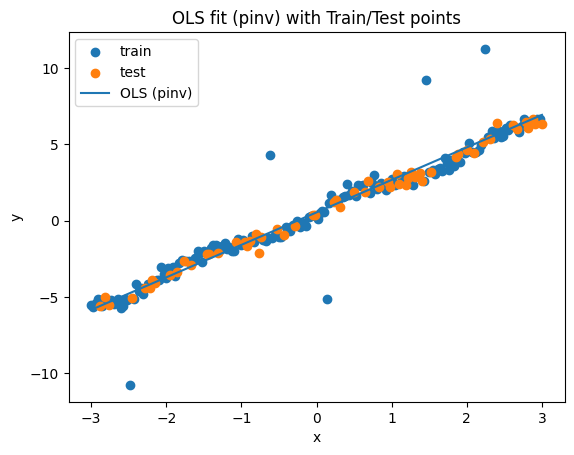

In [8]:

# Fit visualization (train + test) for pinv
plt.figure()
plt.scatter(df_train["x"], df_train["y"], label="train")
plt.scatter(df_test["x"], df_test["y"], label="test")
xline = np.linspace(df["x"].min(), df["x"].max(), 300)
plt.plot(xline, predict_ols(beta_pinv, xline), label="OLS (pinv)")
plt.title("OLS fit (pinv) with Train/Test points")
plt.xlabel("x"); plt.ylabel("y")
plt.legend()
plt.show()


### Reflection — Visual Interpretation of the OLS Fit

The plot above shows:
- The **training points** and **test points** as scatter plots.
- The **OLS prediction line (pinv)** across the full range of `x`.

Analyze and discuss the following:

1) **Overall fit**
- Does the OLS line capture the main trend of the data?
- Are there regions where the model systematically over- or under-predicts?

2) **Train vs Test behavior**
- Do the predictions generalize well to test points?
- Are errors similar across both sets, or is there visible overfitting/underfitting?

3) **Noise and outlier effects**
- How do the noisy or outlier points influence the fitted line?
- Would MAE-based regression likely produce a visually different line? Why?

4) **Model limitations**
- If your true function included a ripple or nonlinearity, does the linear model visibly fail to capture it?
- What would you expect to change if you added nonlinear features (e.g., \(x^2\)) to the design matrix?

> Write 5–7 sentences describing what this visualization reveals about the **model’s fit quality**, **robustness**, and **generalization** across train and test data.


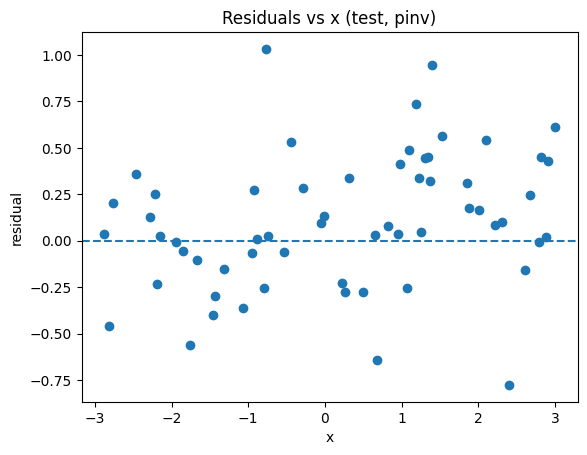

In [9]:

# Residuals on test (pinv)
plt.figure()
res = df_test_eval["yhat"] - df_test_eval["y"]
plt.scatter(df_test_eval["x"], res)
plt.axhline(0, linestyle="--")
plt.title("Residuals vs x (test, pinv)")
plt.xlabel("x"); plt.ylabel("residual")
plt.show()


### Reflection — Interpreting the Residual Plot (Test Set, pinv)

The plot above shows the **residuals** (prediction errors) on the test set for the OLS model fitted with `pinv`.

Analyze and discuss the following:

1) **Pattern detection**
- Are residuals randomly scattered around zero, or do they show a clear pattern (e.g., curvature, trend, or clusters)?
- What would a random, pattern-free residual plot indicate about model correctness?

2) **Nonlinearity**
- Do residuals suggest that the true relationship between `x` and `y` is nonlinear?
- If so, where does the linear model fail — at the extremes, or in certain midrange regions?

3) **Heteroscedasticity**
- Does the spread (variance) of residuals change with `x`?  
  (e.g., larger errors for large |x| values?)
- What could that mean about noise structure or model misspecification?

4) **Outliers**
- Are there any points with unusually large residuals?
- How might these affect MSE vs MAE and the fitted slope/intercept?

5) **Model adequacy**
- Based on this plot, do you think the OLS model is well-specified for this dataset?
- If not, what modeling step (e.g., feature transformation) might reduce systematic residuals?

> Summarize your conclusions in 5–6 sentences, focusing on **randomness vs structure** in residuals, **model fit quality**, and **potential improvements**.


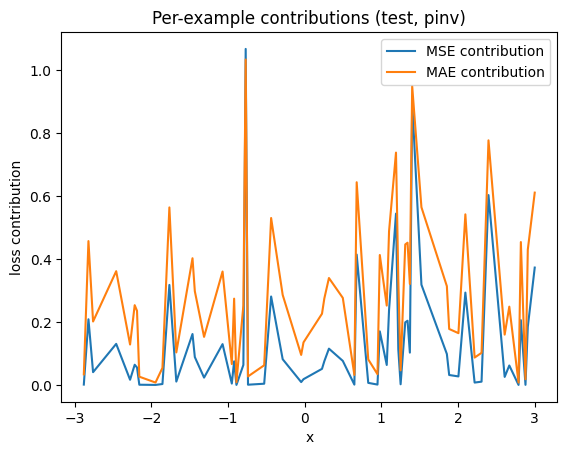

In [10]:

# Per-example contribution comparison on test (pinv)
plt.figure()
plt.plot(df_test_eval["x"], df_test_eval["mse_contrib"], label="MSE contribution")
plt.plot(df_test_eval["x"], df_test_eval["mae_contrib"], label="MAE contribution")
plt.title("Per-example contributions (test, pinv)")
plt.xlabel("x"); plt.ylabel("loss contribution")
plt.legend()
plt.show()


### Reflection — Comparing Per-Example Loss Contributions (Test Set, pinv)

This plot shows how individual test examples contribute to the total **MSE** and **MAE** losses.

Please analyze and discuss the following:

1) **Overall shape**
- How do the **MSE** and **MAE** contribution curves differ across `x`?
- Are they similar for most points, or do they diverge sharply at specific locations?

2) **Outlier sensitivity**
- Identify where the **MSE** spikes relative to **MAE**.
- Why does MSE amplify large errors so dramatically compared to MAE?

3) **Interpretation of specific regions**
- Do the highest contributions occur near true data outliers, or in regions where the model systematically misfits (e.g., nonlinear zones)?
- What does this reveal about which parts of the input space dominate each metric?

4) **Metric robustness**
- Based on the curves, which metric (MSE or MAE) seems more stable across examples?
- How does this stability relate to the robustness of the evaluation?

5) **Takeaway**
- In a short paragraph (4–6 sentences), summarize what this figure tells you about how MSE and MAE “see” model error differently,  
  and which metric better reflects the *typical* performance versus rare but extreme mistakes.



## Part F — (Mini) K-Fold Evaluation (Optional)

We implement a small **k-fold** helper to report average MSE/MAE without any model selection.


In [11]:

def kfold_indices(n_samples: int, k: int, seed: int = 123):
    rng = np.random.default_rng(seed)
    indices = np.arange(n_samples)
    rng.shuffle(indices)
    folds = np.array_split(indices, k)
    for i in range(k):
        test_idx = folds[i]
        train_idx = np.concatenate([folds[j] for j in range(k) if j != i])
        yield train_idx, test_idx

def kfold_ols_report(x: np.ndarray, y: np.ndarray, k: int = 5):
    mses, maes = [], []
    for tr_idx, te_idx in kfold_indices(len(x), k):
        beta = fit_ols_pinv(x[tr_idx], y[tr_idx])
        yhat = predict_ols(beta, x[te_idx])
        mses.append(mse(y[te_idx], yhat))
        maes.append(mae(y[te_idx], yhat))
    return float(np.mean(mses)), float(np.std(mses)), float(np.mean(maes)), float(np.std(maes))

m, s, ma, sa = kfold_ols_report(df["x"].values, df["y"].values, k=5)
print(f"5-fold: MSE mean={m:.4f}±{s:.4f} | MAE mean={ma:.4f}±{sa:.4f}")


5-fold: MSE mean=1.0149±0.9969 | MAE mean=0.4614±0.1672


### Reflection — Interpreting the K-Fold Cross-Validation Results

The code above performs **k-fold cross-validation** using the **closed-form OLS model** (via `pinv`), computing both **MSE** and **MAE** across all folds. The printed result shows the **mean** and **standard deviation** of each metric.

Analyze and discuss the following:

1) **Purpose and logic**
- Explain in your own words what k-fold cross-validation does and why it’s used.
- How does this evaluation differ from a single train/test split?

2) **Metric interpretation**
- Compare the reported `MSE mean` and `MAE mean`.  
  Are they close or quite different? What does that imply about outlier sensitivity in your data?
- Which metric provides a more *robust* summary of model performance?

3) **Variance across folds**
- Look at the `± std` values for both metrics.  
  Are they small (indicating stable generalization) or large (indicating variability across folds)?
- What might cause high variance between folds?

4) **Model evaluation insight**
- Does the average MSE/MAE seem consistent with your earlier single split results?  
- Based on these values, would you say the OLS model generalizes well on this dataset?

5) **Critical reflection**
- If you increased `k` (e.g., from 5 to 10), what effect would you expect on the mean and variance of the metrics?
- Would the results change meaningfully if you used `lstsq` instead of `pinv`?

> Write a brief discussion (5–7 sentences) interpreting both the **quantitative results** (means and standard deviations) and the **conceptual implications** of cross-validation for this regression experiment.



## Part G — Outlier Sensitivity (Evaluation-Only Experiment)

**Goal:** Quantify how **MSE** vs **MAE** change as we vary the *fraction* or *magnitude* of outliers.  
We keep the *fitting procedure fixed* (OLS from clean train subset if you want), and only change the **evaluation data**.

**TODO:** Extend the loop below (different `outlier_frac` and `outlier_mag`) and produce a plot of `metric vs parameter`.


In [ ]:
# ----------------------------- Outlier Sensitivity Experiment -----------------------------
# Baseline: model is already fitted on the current training data (beta_pinv)
# We'll *evaluate* its robustness by introducing synthetic outliers into the test data.

# TODO: define a few outlier fractions and magnitudes to test
# fracs = ...
# mags  = ...

records = []  # to store results for each (frac, mag) configuration

# TODO: extract test x values and their clean (noise-free) ground-truth targets
# x_eval = ...
# y_clean_eval = ...

# TODO: loop over all outlier fractions and magnitudes
# for f in fracs:
#     for M in mags:
#         # TODO: generate Gaussian noise for the evaluation set
#         # noise = ...

#         # TODO: inject outliers in 'k' randomly chosen points
#         # k = int(round(f * len(x_eval)))
#         # if k > 0:
#         #     idx = np.random.choice(len(x_eval), size=k, replace=False)
#         #     noise[idx] += np.random.choice([M, -M], size=k)

#         # TODO: create the noisy test labels
#         # y_eval = ...

#         # TODO: get predictions from the *fixed* OLS model (no retraining)
#         # yhat_eval = ...

#         # TODO: compute MSE and MAE for this configuration and record results
#         # records.append({
#         #     "outlier_frac": f,
#         #     "outlier_mag": M,
#         #     "MSE": ...,
#         #     "MAE": ...,
#         # })

# Keep result construction code (no need for TODOs here)
df_out = pd.DataFrame(records)
df_out.head()


,outlier_frac,outlier_mag,MSE,MAE
0,0.00,3.0,0.215365,0.371617
1,0.00,6.0,0.181132,0.346973
2,0.00,10.0,0.200602,0.374844
3,0.01,3.0,0.356826,0.400756
4,0.01,6.0,0.676918,0.423099


In [ ]:
import unittest
import numpy as np
import pandas as pd

class TestOutlierSensitivityTable(unittest.TestCase):
    def test_table_structure(self):
        # df_out must exist and be a DataFrame with expected columns
        required = {"outlier_frac", "outlier_mag", "MSE", "MAE"}
        self.assertIsInstance(df_out, pd.DataFrame)
        self.assertTrue(required.issubset(set(df_out.columns)))

        # Row count should equal len(fracs) * len(mags)
        self.assertEqual(len(df_out), len(fracs) * len(mags))

        # Every combination of (frac, mag) should appear
        observed = set(map(tuple, df_out[["outlier_frac", "outlier_mag"]].values))
        expected = {(f, M) for f in fracs for M in mags}
        self.assertSetEqual(observed, expected)

    def test_metrics_nonnegative_and_finite(self):
        # MSE/MAE must be finite and non-negative
        for col in ["MSE", "MAE"]:
            vals = df_out[col].to_numpy()
            self.assertTrue(np.all(np.isfinite(vals)), f"{col} contains non-finite values")
            self.assertTrue(np.all(vals >= 0.0), f"{col} contains negative values")

    def test_no_dependency_on_model_refit(self):
        # Sanity: the model used here is fixed (no refit per config),
        # so predictions depend only on x_eval and beta_pinv, not on outlier settings.
        # We can't check equality across rows (labels change), but we can at least
        # confirm yhat_eval shape matches x_eval length.
        yhat_eval = predict_ols(beta_pinv, df_test["x"].values)
        self.assertEqual(len(yhat_eval), len(df_test))

    def test_frac_and_mag_types(self):
        # outlier_frac should be within [0, 1]; outlier_mag should be >= 0
        self.assertTrue(np.all((df_out["outlier_frac"].values >= 0.0) &
                               (df_out["outlier_frac"].values <= 1.0)))
        self.assertTrue(np.all(df_out["outlier_mag"].values >= 0.0))

suite = unittest.TestLoader().loadTestsFromTestCase(TestOutlierSensitivityTable)
unittest.TextTestRunner(verbosity=2).run(suite)


# Deterministic probe: non-decreasing error as outlier magnitude grows (fixed noise & indices)
rng = np.random.default_rng(0)
x_eval = df_test["x"].values
y_clean_eval = f_true(x_eval)
yhat_fixed = predict_ols(beta_pinv, x_eval)

probe_fracs = [0.0, 0.05]   # try no-outlier and a small fraction
probe_mags  = [0.0, 3.0, 6.0, 10.0]

for f in probe_fracs:
    base_noise = sigma * rng.standard_normal(len(x_eval))
    k = int(round(f * len(x_eval)))
    idx = rng.choice(len(x_eval), size=k, replace=False) if k > 0 else np.array([], dtype=int)

    mses, maes = [], []
    for M in probe_mags:
        noise = base_noise.copy()
        if k > 0:
            # Use the SAME indices and only scale the outlier kick by magnitude M
            kicks = rng.choice([1.0, -1.0], size=k)  # fixed signs per f across mags
            noise[idx] += M * kicks
        y_eval = y_clean_eval + noise
        mses.append(mse(y_eval, yhat_fixed))
        maes.append(mae(y_eval, yhat_fixed))

    print(f"[f={f:.2f}] MSE by mag:", np.round(mses, 4))
    print(f"[f={f:.2f}] MAE by mag:", np.round(maes, 4))
    # Expectation (not asserted): sequences should be non-decreasing as M increases


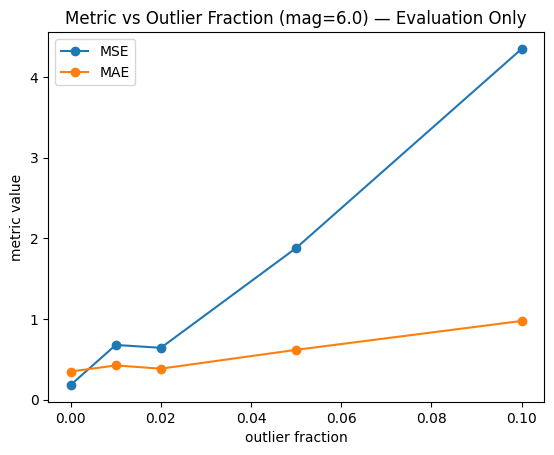

In [13]:

# Simple slice: plot metric vs outlier fraction for a fixed magnitude (e.g., 6.0)
subset = df_out[df_out["outlier_mag"] == 6.0].sort_values("outlier_frac")

plt.figure()
plt.plot(subset["outlier_frac"], subset["MSE"], marker="o", label="MSE")
plt.plot(subset["outlier_frac"], subset["MAE"], marker="o", label="MAE")
plt.title("Metric vs Outlier Fraction (mag=6.0) — Evaluation Only")
plt.xlabel("outlier fraction"); plt.ylabel("metric value")
plt.legend()
plt.show()


### Reflection — Metric Trends vs Outlier Fraction (mag = 6.0)

The plot above shows how the **MSE** and **MAE** metrics change as the proportion of outliers increases, while the **outlier magnitude** is fixed at 6.0.

Analyze and discuss the following:

1) **Overall trend**
- How do MSE and MAE behave as the outlier fraction increases?  
- Do both grow at a similar rate, or does one escalate faster?

2) **Relative sensitivity**
- Which metric is more affected by the presence of even a small number of outliers?  
- Why does this difference occur mathematically?

3) **Interpretation of slope**
- If MSE rises much faster than MAE, what does that reveal about how squared error penalizes extreme deviations?  
- How would this affect model evaluation in noisy or outlier-heavy datasets?

4) **Stability and robustness**
- At what range of outlier fractions do the metrics remain relatively stable?  
- Which metric would you trust more for assessing performance in practical, imperfect data?

5) **Critical insight**
- If you repeated this test with a smaller outlier magnitude (e.g., 3.0), what pattern would you expect?  
- How does this experiment illustrate the conceptual difference between **error magnitude sensitivity** and **robustness**?

> Write 5–7 sentences discussing the trends you observe, connecting them to the mathematical properties of MSE and MAE and what they imply about model robustness under contamination.



## Part H — Bring Your Own Data/Predictions (TODO)

You can **replace** the synthetic data with your own CSV or **plug in** predictions from another model (still **fixed**).
- Regression CSV must have: `x` (or multiple feature columns), `y`.  
- If you already have predictions from elsewhere, provide a CSV with `y_true`, `y_pred` and compute metrics directly.

> **Note:** If you switch to multiple features, adjust the **design matrix** function accordingly (add columns, keep leading bias).


In [14]:

# === DIRECT PREDICTIONS CSV (TODO) ===
# df_pred = pd.read_csv("path/to/your_predictions.csv")
# print(df_pred.head())
# print("MSE:", mse(df_pred["y_true"].values, df_pred["y_pred"].values))
# print("MAE:", mae(df_pred["y_true"].values, df_pred["y_pred"].values))

# === RAW DATA CSV (TODO) ===
# df_raw = pd.read_csv("path/to/your_regression_data.csv")
# # If multiple features exist, change design matrix builder:
# # def design_matrix(X2d: np.ndarray):
# #     X2d = np.asarray(X2d)
# #     return np.concatenate([np.ones((len(X2d), 1)), X2d], axis=1)
# # Then fit/predict as done above.



## Summary & Reflection

- **Closed-form OLS** via `pinv`/`lstsq` avoids gradients and is numerically stable vs `inv(XᵀX)`.
- **MSE vs MAE:** MSE emphasizes large errors (**outliers**), while MAE is more robust but less smooth.
- **Disagreement mining** (per-example contributions) surfaces exactly **where** and **why** metrics diverge.
- **K-fold** offers a stable performance estimate without model selection.
- **Outlier sensitivity** experiments show how reporting can change under distribution shifts—even with a **fixed** model.

**Write-up (required):**  
Add 2–3 paragraphs summarizing your experiments (metrics tables + plots). Include at least two disagreeing test examples and explain them.
